Seongmin Hwang 20102127

Marion Schmitt 25170158

Seungwon Jeon 16102288

**Data Science Practice : Project (FIXED VERSION)**

# Analyzing the Relationship between News Bias and Audience Influence

**Objective: Predict the influence of a media outlet based on its bias**

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

In [ ]:
import pandas as pd
import numpy as np
import json
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud


# Korean Font Setting
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

### Bias Lexique
Load immoral sentences from AIHub

In [ ]:
# AI HUB (json) file
folder = "data_aihub" # fichier en .7z
files_to_load = [f"talksets-train-{i}.json" for i in range(1, 6)]

aihub_data = []
for file_name in files_to_load:
    path = os.path.join(folder, file_name)
    with open(path, 'r', encoding='utf-8') as f :
        aihub_data.extend(json.load(f))

print(f"Total AI Hub data loaded: {len(aihub_data):,}")

Total AI Hub data loaded: 104,805


In [ ]:
# Extract immoral sentences
immoral_sentences = [
    s["text"]
    for entry in aihub_data
    for s in entry.get("sentences", [])
    if s.get("is_immoral") is True and "text" in s
]

print(f"Total immoral sentences: {len(immoral_sentences):,}")
print("\nSample immoral sentences:")
for i, sent in enumerate(immoral_sentences[:5]):
    print(f"{i+1}. {sent}")

Total immoral sentences: 200,206

Sample immoral sentences:
1. 부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네
2. 맞아. 사람들이 진짜 개념이없다
3. 저렇게는 살지 말아야지
4. 그러게 게으르고 멍청한 사람들은 맞아야해
5. 인방 보는 남자는 거르는게 맞다


### Bias Score
Load media news data

In [ ]:
df_bigkinds = pd.read_excel('NewsResult_20241127-20251127.xlsx', sheet_name='sheet')
print("Columns in BigKinds data:")
print(df_bigkinds.columns.tolist())
print(f"\nTotal news articles: {len(df_bigkinds):,}")

# Columns definition
MEDIA_COL = "언론사"
TEXT_COL = "본문"  # Use 본문 instead of 키워드

df_bigkinds.dropna(subset=[MEDIA_COL, TEXT_COL], inplace=True)
print(f"After dropping NaN: {len(df_bigkinds):,}")

# Extract first 1000 characters
df_bigkinds["excerpt"] = df_bigkinds[TEXT_COL].astype(str).str[:1000]

# Show sample
print("\nSample excerpt:")
print(df_bigkinds["excerpt"].iloc[0][:200])

Columns in BigKinds data:
['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3', '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드', '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부']

Total news articles: 20,000
After dropping NaN: 20,000

Sample excerpt:
각종 피싱 범죄에 악용돼 기피 대상이 된 발신 번호 ‘070’을 국내 일반 휴대전화 통합 식별번호 ‘010’으로 바꿔 350억 원대 보이스 피싱 범죄 조직원이 무더기로 붙잡혔다.
경기남부경찰청 형사기동대는 전기통신사업법 위반 등 혐의로 국내 관리자 20대 여성 A씨 등 63명을 붙잡아, 56명을 구속 송치했다고 27일 밝혔다.
이들은 해외 총책으로부터 ..


## **Immoral lexic :**

### Method A : N-gram (2,3) with CountVectorizer

In [ ]:
# N-gram : unethical lexicon
vectorizer = CountVectorizer(
    ngram_range=(2, 3),
    min_df=5,
)

X_immoral = vectorizer.fit_transform(immoral_sentences)
unethical_terms = vectorizer.get_feature_names_out()

print(f"Total unethical N-grams extracted: {len(unethical_terms):,}")
print("\nSample unethical N-grams:")
for i, term in enumerate(unethical_terms[:20]):
    print(f"{i+1}. {term}")

Total unethical N-grams extracted: 10,992

Sample unethical N-grams:
1. 1도 모르면서
2. 1도 없는
3. 1도 없는데
4. 1도 없어
5. 1도 없으면서
6. 1도 없음
7. 1일 1망언
8. 200도 못버는
9. 200은 버냐
10. 20대 여자
11. 20대 초반
12. 25살 넘으면
13. 2년 동안
14. 2차 가해
15. 30 40대
16. 3일에 번씩
17. 4년제 나왔다고
18. 4년제 나왔다고 대기업
19. tv 나와서
20. ㄹㅇ ㅋㅋ


### Method B : TF-IDF with lexical_units (1-gram)

In [ ]:
# TF-IDF lexical units
tfidf_unigram = TfidfVectorizer(
    ngram_range=(1, 1),
    min_df=5,
    max_df=0.9
)

X_immoral_unigram = tfidf_unigram.fit_transform(immoral_sentences)
unigram_vocab_tfidf = tfidf_unigram.get_feature_names_out()

print(f"Total TF-IDF unigrams extracted: {len(unigram_vocab_tfidf ):,}")
print("\nSample TF-IDF unigrams:")
for i, term in enumerate(unigram_vocab_tfidf[:20]):
    print(f"{i+1}. {term}")

Total TF-IDF unigrams extracted: 28,080

Sample TF-IDF unigrams:
1. 10
2. 100
3. 1000원
4. 100년
5. 100대
6. 100만
7. 100만원
8. 100명
9. 100배
10. 100일
11. 100점
12. 100퍼
13. 100퍼센트
14. 100프로
15. 10년
16. 10년은
17. 10대
18. 10만
19. 10만원
20. 10명


### Method C : N-gram (2,3) with TF-IDF

In [ ]:
# TF-IDF n-gram (2,3)
tfidf_ngram = TfidfVectorizer(
    ngram_range=(2, 3),
    min_df=5,
    max_df=0.9
)

X_immoral_tfidf = tfidf_ngram.fit_transform(immoral_sentences)
ngram_vocab_tfidf = tfidf_ngram.get_feature_names_out()

print(f"Total TF-IDF N-gram extracted: {len(ngram_vocab_tfidf):,}")
print("\nSample TF-IDF N-gram:")
for i, term in enumerate(ngram_vocab_tfidf[:20]):
    print(f"{i+1}. {term}")

Total TF-IDF N-gram extracted: 10,992

Sample TF-IDF N-gram:
1. 1도 모르면서
2. 1도 없는
3. 1도 없는데
4. 1도 없어
5. 1도 없으면서
6. 1도 없음
7. 1일 1망언
8. 200도 못버는
9. 200은 버냐
10. 20대 여자
11. 20대 초반
12. 25살 넘으면
13. 2년 동안
14. 2차 가해
15. 30 40대
16. 3일에 번씩
17. 4년제 나왔다고
18. 4년제 나왔다고 대기업
19. tv 나와서
20. ㄹㅇ ㅋㅋ


## **Count immoral :**

### Method A : N-gram (2,3) with CountVectorizer

In [ ]:
# Count N-grams using method A
vectorizer_news = CountVectorizer(
    vocabulary=unethical_terms,
    ngram_range=(2, 3)
)

X_news = vectorizer_news.transform(df_bigkinds["excerpt"])
unethical_counts = np.asarray(X_news.sum(axis=1)).ravel()

# Compute bias score
df_bigkinds["unethical_count_A"] = unethical_counts
df_bigkinds["word_count"] = df_bigkinds["excerpt"].str.split().str.len()
df_bigkinds["Bias_Score_A"] = (df_bigkinds["unethical_count_A"] / (df_bigkinds["word_count"] + 1)) * 100

# Data validation
print("\n=== Data Validation (Method A) ===")

print("\nBias Score statistics:")
print(df_bigkinds["Bias_Score_A"].describe())

print("\nWord count statistics:")
print(df_bigkinds["word_count"].describe())

print("\nUnethical count distribution:")
print(df_bigkinds["unethical_count_A"].value_counts().head(10))


=== Data Validation (Method A) ===

Bias Score statistics:
count    20000.000000
mean         0.136072
std          0.652135
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.615385
Name: Bias_Score_A, dtype: float64

Word count statistics:
count    20000.000000
mean        43.089700
std          7.069183
min          1.000000
25%         42.000000
50%         44.000000
75%         47.000000
max         59.000000
Name: word_count, dtype: float64

Unethical count distribution:
unethical_count_A
0    19016
1      903
2       69
3       10
4        1
5        1
Name: count, dtype: int64


### Method B : TF-IDF with lexical_units (1-gram)

In [ ]:
# Count 1-gram using Method B
tfidf_unigram_news = CountVectorizer(
    vocabulary=unigram_vocab_tfidf,
    ngram_range=(1, 1)
)

X_news_unigram = tfidf_unigram_news.transform(df_bigkinds["excerpt"])
unethical_counts_unigram = np.asarray(X_news_unigram.sum(axis=1)).ravel()

# Compute bias score
df_bigkinds["unethical_count_B"] = unethical_counts_unigram
df_bigkinds["Bias_Score_B"] = (df_bigkinds["unethical_count_B"] / (df_bigkinds["word_count"] + 1)) * 100

# Data validation
print("\n=== Data Validation (Method B) ===")

print("\nBias Score statistics:")
print(df_bigkinds["Bias_Score_B"].describe())

print("\nWord count statistics:")
print(df_bigkinds["word_count"].describe())

print("\nUnethical count distribution:")
print(df_bigkinds["unethical_count_B"].value_counts().head(10))


=== Data Validation (Method B) ===

Bias Score statistics:
count    20000.000000
mean        27.535046
std          9.479795
min          0.000000
25%         21.276596
50%         27.083333
75%         33.333333
max         67.307692
Name: Bias_Score_B, dtype: float64

Word count statistics:
count    20000.000000
mean        43.089700
std          7.069183
min          1.000000
25%         42.000000
50%         44.000000
75%         47.000000
max         59.000000
Name: word_count, dtype: float64

Unethical count distribution:
unethical_count_B
11    1703
12    1702
10    1608
13    1538
14    1446
9     1339
15    1296
16    1180
8     1177
17     955
Name: count, dtype: int64


### Method C : N-gram (2,3) with TF-IDF

In [ ]:
# Count N-gram using Method C TF-IDF
tfidf_ngram_news = CountVectorizer(
    vocabulary=ngram_vocab_tfidf,
    ngram_range=(2, 3)
)
X_news_tfidf = tfidf_ngram.transform(df_bigkinds["excerpt"])
unethical_counts_tfidf = np.asarray(X_news_tfidf.sum(axis=1)).ravel()

# Compute bias score
df_bigkinds["unethical_count_C"] = unethical_counts_tfidf
df_bigkinds["Bias_Score_C"] = (df_bigkinds["unethical_count_C"] / (df_bigkinds["word_count"] + 1)) * 100

# Data validation
print("\n=== Data Validation (Method C) ===")

print("\nBias Score statistics:")
print(df_bigkinds["Bias_Score_C"].describe())

print("\nWord count statistics:")
print(df_bigkinds["word_count"].describe())

print("\nUnethical count distribution:")
print(df_bigkinds["unethical_count_C"].value_counts().head(10))


=== Data Validation (Method C) ===

Bias Score statistics:
count    20000.000000
mean         0.129602
std          0.611552
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.250000
Name: Bias_Score_C, dtype: float64

Word count statistics:
count    20000.000000
mean        43.089700
std          7.069183
min          1.000000
25%         42.000000
50%         44.000000
75%         47.000000
max         59.000000
Name: word_count, dtype: float64

Unethical count distribution:
unethical_count_C
0.000000    19016
1.000000      909
1.414214        6
1.414181        5
1.412358        3
1.413982        3
1.414098        3
1.412855        2
1.413188        2
1.414188        2
Name: count, dtype: int64


In [ ]:
# Prepare descriptive statistics for each method
methods = ["A", "B", "C"]
bias_cols = ["Bias_Score_A", "Bias_Score_B", "Bias_Score_C"]
count_cols = ["unethical_count_A", "unethical_count_B", "unethical_count_C"]

summary_stats = []

for m, b_col, c_col in zip(methods, bias_cols, count_cols):
    bias_desc = df_bigkinds[b_col].describe()
    count_desc = df_bigkinds[c_col].describe()

    summary_stats.append({
        "Method": m,
        "Bias_Count": int(bias_desc["count"]),
        "Bias_Mean": bias_desc["mean"],
        "Bias_Std": bias_desc["std"],
        "Bias_Min": bias_desc["min"],
        "Bias_25%": bias_desc["25%"],
        "Bias_50%": bias_desc["50%"],
        "Bias_75%": bias_desc["75%"],
        "Bias_Max": bias_desc["max"],

    })

summary_table = pd.DataFrame(summary_stats)

# Display nicely formatted table
summary_table.style.format({
    "Bias_Mean": "{:.2f}", "Bias_Std": "{:.2f}", "Bias_Min": "{:.2f}", "Bias_25%": "{:.2f}",
    "Bias_50%": "{:.2f}", "Bias_75%": "{:.2f}", "Bias_Max": "{:.2f}",
}).set_caption("Detailed Comparison of Bias Detection Methods")


,Method,Bias_Count,Bias_Mean,Bias_Std,Bias_Min,Bias_25%,Bias_50%,Bias_75%,Bias_Max
0,A,20000,0.14,0.65,0.00,0.00,0.00,0.00,9.62
1,B,20000,27.54,9.48,0.00,21.28,27.08,33.33,67.31
2,C,20000,0.13,0.61,0.00,0.00,0.00,0.00,6.25


### Exploratory Data Analysis

### Method A: N-gram (2,3) with CountVectorizer

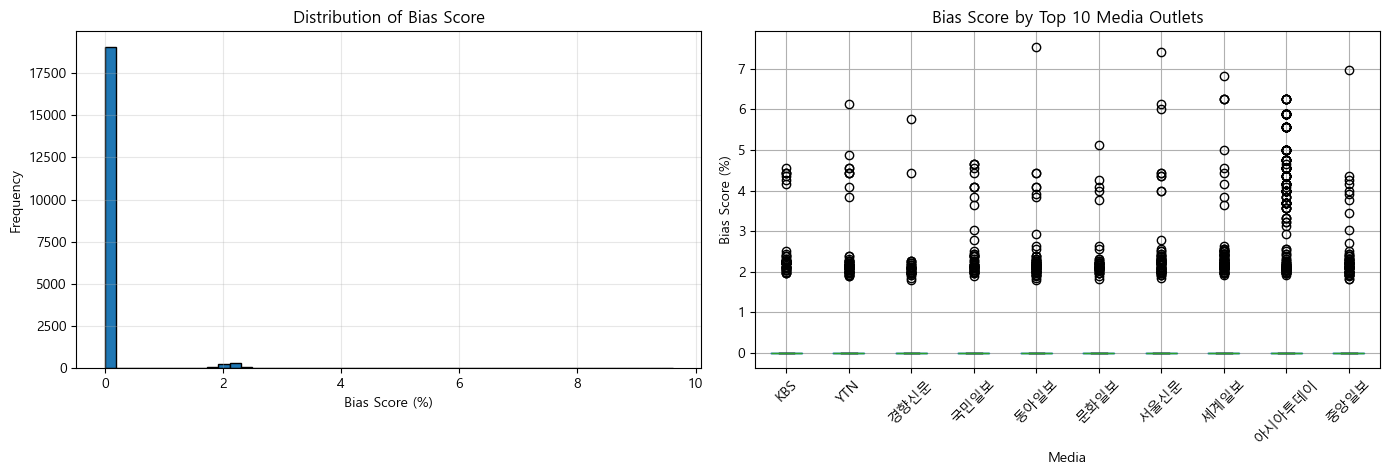


=== Bias Score Summary by Media ===
         Mean  Median    Std  Article Count
언론사                                        
시사IN    0.661     0.0  1.581             25
아시아투데이  0.418     0.0  1.301           1996
세계일보    0.172     0.0  0.681           1487
한겨레     0.159     0.0  0.672            798
MBC     0.151     0.0  0.591            410
동아일보    0.141     0.0  0.596           1283
중앙일보    0.137     0.0  0.588           1293
국민일보    0.132     0.0  0.603           1020
서울신문    0.106     0.0  0.549           1726
조선일보    0.099     0.0  0.503            946
문화일보    0.089     0.0  0.468           1277
한국일보    0.079     0.0  0.414            955
내일신문    0.078     0.0  0.453            443
YTN     0.077     0.0  0.449           2377
경향신문    0.073     0.0  0.417           1128


In [ ]:
# Distribution of Bias Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_bigkinds['Bias_Score_A'], bins=50, edgecolor='black')
axes[0].set_xlabel('Bias Score (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Bias Score')
axes[0].grid(True, alpha=0.3)

# Box plot by media
top_media = df_bigkinds[MEDIA_COL].value_counts().head(10).index
df_top = df_bigkinds[df_bigkinds[MEDIA_COL].isin(top_media)]
df_top.boxplot(column='Bias_Score_A', by=MEDIA_COL, ax=axes[1], rot=45)
axes[1].set_title('Bias Score by Top 10 Media Outlets')
axes[1].set_xlabel('Media')
axes[1].set_ylabel('Bias Score (%)')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Summary by media
print("\n=== Bias Score Summary by Media ===")
media_summary = df_bigkinds.groupby(MEDIA_COL).agg({
    'Bias_Score_A': ['mean', 'median', 'std', 'count']
}).round(3)
media_summary.columns = ['Mean', 'Median', 'Std', 'Article Count']
print(media_summary.sort_values('Mean', ascending=False).head(15))

### Method B: TF-IDF with lexical_units (1-gram)

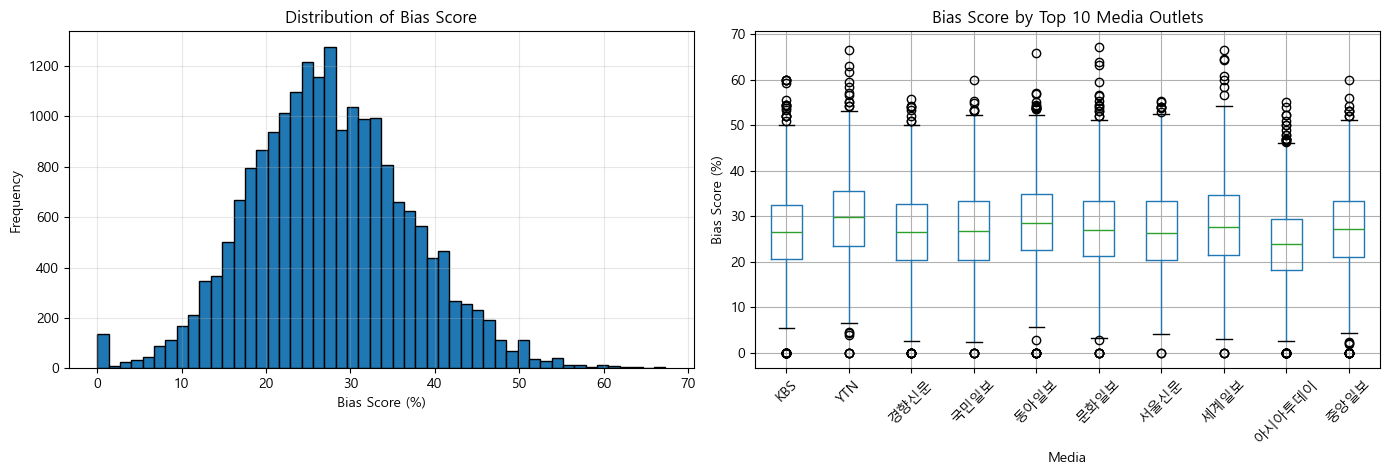


=== Bias Score Summary by Media ===
        Mean  Median     Std  Article Count
언론사                                        
시사IN  37.303  37.778  10.686             25
SBS   30.195  30.000   9.072            335
YTN   29.703  29.787   8.875           2377
조선일보  29.466  29.167  10.203            946
동아일보  28.813  28.571   9.536           1283
한국일보  28.330  27.907  10.022            955
세계일보  28.237  27.660   9.778           1487
한겨레   27.744  27.362   9.152            798
MBC   27.624  26.667   8.362            410
문화일보  27.551  27.083   9.334           1277
중앙일보  27.526  27.273   9.606           1293
국민일보  27.157  26.748   9.381           1020
서울신문  27.040  26.365   9.451           1726
KBS   26.807  26.667   9.458           2085
OBS   26.781  26.190   7.971            416


In [ ]:
# Distribution of Bias Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_bigkinds['Bias_Score_B'], bins=50, edgecolor='black')
axes[0].set_xlabel('Bias Score (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Bias Score')
axes[0].grid(True, alpha=0.3)

# Box plot by media
top_media = df_bigkinds[MEDIA_COL].value_counts().head(10).index
df_top = df_bigkinds[df_bigkinds[MEDIA_COL].isin(top_media)]
df_top.boxplot(column='Bias_Score_B', by=MEDIA_COL, ax=axes[1], rot=45)
axes[1].set_title('Bias Score by Top 10 Media Outlets')
axes[1].set_xlabel('Media')
axes[1].set_ylabel('Bias Score (%)')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Summary by media
print("\n=== Bias Score Summary by Media ===")
media_summary = df_bigkinds.groupby(MEDIA_COL).agg({
    'Bias_Score_B': ['mean', 'median', 'std', 'count']
}).round(3)
media_summary.columns = ['Mean', 'Median', 'Std', 'Article Count']
print(media_summary.sort_values('Mean', ascending=False).head(15))

### Method C: N-gram (2,3) with TF-IDF

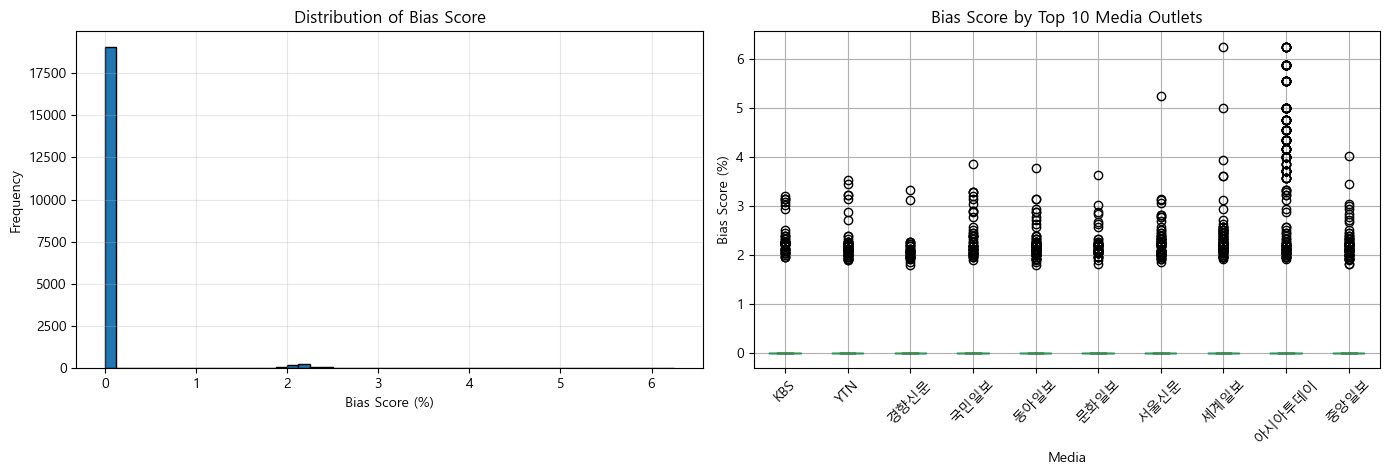


=== Bias Score Summary by Media ===
         Mean  Median    Std  Article Count
언론사                                        
시사IN    0.502     0.0  1.080             25
아시아투데이  0.417     0.0  1.298           1996
세계일보    0.162     0.0  0.615           1487
한겨레     0.146     0.0  0.563            798
MBC     0.142     0.0  0.541            410
동아일보    0.132     0.0  0.533           1283
중앙일보    0.129     0.0  0.530           1293
국민일보    0.121     0.0  0.532           1020
서울신문    0.096     0.0  0.468           1726
조선일보    0.094     0.0  0.463            946
문화일보    0.084     0.0  0.429           1277
한국일보    0.078     0.0  0.404            955
SBS     0.073     0.0  0.397            335
YTN     0.071     0.0  0.394           2377
내일신문    0.070     0.0  0.395            443


In [ ]:
# Distribution of Bias Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_bigkinds['Bias_Score_C'], bins=50, edgecolor='black')
axes[0].set_xlabel('Bias Score (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Bias Score')
axes[0].grid(True, alpha=0.3)

# Box plot by media
top_media = df_bigkinds[MEDIA_COL].value_counts().head(10).index
df_top = df_bigkinds[df_bigkinds[MEDIA_COL].isin(top_media)]
df_top.boxplot(column='Bias_Score_C', by=MEDIA_COL, ax=axes[1], rot=45)
axes[1].set_title('Bias Score by Top 10 Media Outlets')
axes[1].set_xlabel('Media')
axes[1].set_ylabel('Bias Score (%)')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Summary by media
print("\n=== Bias Score Summary by Media ===")
media_summary = df_bigkinds.groupby(MEDIA_COL).agg({
    'Bias_Score_C': ['mean', 'median', 'std', 'count']
}).round(3)
media_summary.columns = ['Mean', 'Median', 'Std', 'Article Count']
print(media_summary.sort_values('Mean', ascending=False).head(15))

### Influence Score

In [ ]:
df_traffic = pd.read_excel('datalab_all.xlsx', sheet_name='Sheet1')
print("Columns in traffic data:")
print(df_traffic.columns.tolist())

# Columns definition
ID_COL = '날짜'
MEDIA_COLUMNS = [col for col in df_traffic.columns if col != ID_COL]

# Processing
results_dict = {}
for media in MEDIA_COLUMNS:
    values = pd.to_numeric(df_traffic[media], errors="coerce").dropna()
    results_dict[media] = values.mean()

# Create influence dataframe
influence_df = pd.DataFrame(results_dict.items(), columns=["Media_Name", "AVG_TREND_INDEX"])
influence_df["Influence_Score"] = np.log(influence_df["AVG_TREND_INDEX"] + 1e-6)

# CRITICAL: Standardize media names (한자 → 한글)
# BigKinds uses 한글, Naver Datalab uses 한자
name_mapping = {
    '朝鮮日報': '조선일보',  # ← 조선일보 mapping
    '東亞日報': '동아일보',
    '中央日報': '중앙일보',
    '京鄉新聞': '경향신문',
    '國民日報': '국민일보',
    '文化日報': '문화일보',
    '世界日報': '세계일보',
    '韓國日報': '한국일보',
    '韓겨레': '한겨레',
    '서울新聞': '서울신문',
    '內일新聞': '내일신문',
}

print("\n=== Name Mapping (한자 → 한글) ===")
for hanja, hangul in name_mapping.items():
    if hanja in influence_df['Media_Name'].values:
        print(f"  {hanja} → {hangul}")

influence_df['Media_Name'] = influence_df['Media_Name'].replace(name_mapping)

print("\n=== Influence Score by Media (after name standardization) ===")
print(influence_df.sort_values('Influence_Score', ascending=False))

Columns in traffic data:
['날짜', '경향신문', '국민일보', '내일신문', '동아일보', '문화일보', '서울신문', '세계일보', '아시아투데이', '朝鮮日報', '중앙일보', '한겨레', '한국일보', 'KBS', 'MBC', 'OBS', 'SBS', 'YTN', '시사IN']

=== Name Mapping (한자 → 한글) ===
  朝鮮日報 → 조선일보

=== Influence Score by Media (after name standardization) ===
   Media_Name  AVG_TREND_INDEX  Influence_Score
8        조선일보        26.538091         3.278581
9        중앙일보        12.778797         2.547787
3        동아일보        10.931094         2.391611
12        KBS         6.545381         1.878760
13        MBC         6.028730         1.796536
15        SBS         4.586488         1.523115
0        경향신문         3.683287         1.303806
16        YTN         2.664337         0.979956
4        문화일보         2.415169         0.881770
11       한국일보         2.037097         0.711526
10        한겨레         1.127941         0.120395
1        국민일보         1.060130         0.058393
5        서울신문         0.958815        -0.042057
14        OBS         0.790083        -0.235616

## **Fusion Bias + Influence :**

### Method A: N-gram (2,3) with CountVectorizer

In [ ]:
# Aggregate Bias Score by Media
bias_by_media_A = df_bigkinds.groupby(MEDIA_COL).agg({
    'Bias_Score_A': 'mean',
    'unethical_count_A': 'sum',
    'word_count': 'sum'
}).reset_index()


print(f"Media which extracted from BigKinds (Method A): {len(bias_by_media_A)}개")
print("\nMedia List:")
for media in sorted(bias_by_media_A[MEDIA_COL]):
    print(f"  - {media}")

Media which extracted from BigKinds (Method A): 18개

Media List:
  - KBS
  - MBC
  - OBS
  - SBS
  - YTN
  - 경향신문
  - 국민일보
  - 내일신문
  - 동아일보
  - 문화일보
  - 서울신문
  - 세계일보
  - 시사IN
  - 아시아투데이
  - 조선일보
  - 중앙일보
  - 한겨레
  - 한국일보


### Method B: TF-IDF with lexical_units (1-gram)

In [ ]:
# Aggregate Bias Score by Media
bias_by_media_B = df_bigkinds.groupby(MEDIA_COL).agg({
    'Bias_Score_B': 'mean',
    'unethical_count_B': 'sum',
    'word_count': 'sum'
}).reset_index()


print(f"Media which extracted from BigKinds (Method B): {len(bias_by_media_B)}개")
print("\nMedia List:")
for media in sorted(bias_by_media_B[MEDIA_COL]):
    print(f"  - {media}")

Media which extracted from BigKinds (Method B): 18개

Media List:
  - KBS
  - MBC
  - OBS
  - SBS
  - YTN
  - 경향신문
  - 국민일보
  - 내일신문
  - 동아일보
  - 문화일보
  - 서울신문
  - 세계일보
  - 시사IN
  - 아시아투데이
  - 조선일보
  - 중앙일보
  - 한겨레
  - 한국일보


### Method C : N-gram (2,3) with TF-IDF

In [ ]:
# Aggregate Bias Score by Media
bias_by_media_C = df_bigkinds.groupby(MEDIA_COL).agg({
    'Bias_Score_C': 'mean',
    'unethical_count_C': 'sum',
    'word_count': 'sum'
}).reset_index()


print(f"Media which extracted from BigKinds (Method C): {len(bias_by_media_C)}개")
print("\nMedia List:")
for media in sorted(bias_by_media_C[MEDIA_COL]):
    print(f"  - {media}")

Media which extracted from BigKinds (Method C): 18개

Media List:
  - KBS
  - MBC
  - OBS
  - SBS
  - YTN
  - 경향신문
  - 국민일보
  - 내일신문
  - 동아일보
  - 문화일보
  - 서울신문
  - 세계일보
  - 시사IN
  - 아시아투데이
  - 조선일보
  - 중앙일보
  - 한겨레
  - 한국일보


In [ ]:
methods_bias = {
    "Method A": bias_by_media_A,
    "Method B": bias_by_media_B,
    "Method C": bias_by_media_C
}

for method_name, df_bias in methods_bias.items():
    print(f"\n=== {method_name} ===")

    bigkinds_set = set(df_bias[MEDIA_COL])
    influence_set = set(influence_df['Media_Name'])

    matched = bigkinds_set & influence_set
    only_bigkinds = bigkinds_set - influence_set
    only_influence = influence_set - bigkinds_set

    print(f"Total media in BigKinds: {len(bigkinds_set)}")
    print(f"Total media in Influence data: {len(influence_set)}")
    print(f"Number of media that matched: {len(matched)}")
    if matched:
        print("Matched media:")
        for media in sorted(matched):
            print(f"  - {media}")

    if only_bigkinds:
        print(f"Media only in BigKinds ({len(only_bigkinds)}):")
        for media in sorted(only_bigkinds):
            print(f"  - {media}")

    if only_influence:
        print(f"Media only in Influence ({len(only_influence)}):")
        for media in sorted(only_influence):
            print(f"  - {media}")


=== Method A ===
Total media in BigKinds: 18
Total media in Influence data: 18
Number of media that matched: 18
Matched media:
  - KBS
  - MBC
  - OBS
  - SBS
  - YTN
  - 경향신문
  - 국민일보
  - 내일신문
  - 동아일보
  - 문화일보
  - 서울신문
  - 세계일보
  - 시사IN
  - 아시아투데이
  - 조선일보
  - 중앙일보
  - 한겨레
  - 한국일보

=== Method B ===
Total media in BigKinds: 18
Total media in Influence data: 18
Number of media that matched: 18
Matched media:
  - KBS
  - MBC
  - OBS
  - SBS
  - YTN
  - 경향신문
  - 국민일보
  - 내일신문
  - 동아일보
  - 문화일보
  - 서울신문
  - 세계일보
  - 시사IN
  - 아시아투데이
  - 조선일보
  - 중앙일보
  - 한겨레
  - 한국일보

=== Method C ===
Total media in BigKinds: 18
Total media in Influence data: 18
Number of media that matched: 18
Matched media:
  - KBS
  - MBC
  - OBS
  - SBS
  - YTN
  - 경향신문
  - 국민일보
  - 내일신문
  - 동아일보
  - 문화일보
  - 서울신문
  - 세계일보
  - 시사IN
  - 아시아투데이
  - 조선일보
  - 중앙일보
  - 한겨레
  - 한국일보


### Method A: N-gram (2,3) with CountVectorizer

In [ ]:
# Merge data
final_df_A = bias_by_media_A.merge(
    influence_df,
    left_on=MEDIA_COL,
    right_on="Media_Name",
    how="inner"
)

print(f"\n✓ final dataset (Method A): {len(final_df_A)} media")
print("\n=== Final Dataset ===")
print(final_df_A[[MEDIA_COL, "Bias_Score_A", "Influence_Score"]].sort_values('Bias_Score_A', ascending=False))


✓ final dataset (Method A): 18 media

=== Final Dataset ===
       언론사  Bias_Score_A  Influence_Score
12    시사IN      0.661437        -1.388996
13  아시아투데이      0.417988        -0.319498
11    세계일보      0.172093        -0.562838
16     한겨레      0.159042         0.120395
1      MBC      0.150874         1.796536
8     동아일보      0.140769         2.391611
15    중앙일보      0.137326         2.547787
6     국민일보      0.132243         0.058393
10    서울신문      0.105825        -0.042057
14    조선일보      0.098873         3.278581
9     문화일보      0.088680         0.881770
17    한국일보      0.079455         0.711526
7     내일신문      0.077959        -2.453414
4      YTN      0.077037         0.979956
5     경향신문      0.072920         1.303806
3      SBS      0.072830         1.523115
0      KBS      0.064295         1.878760
2      OBS      0.022094        -0.235616


### Method B : TF-IDF with lexical_units (1-gram)

In [ ]:
# Merge data
final_df_B = bias_by_media_B.merge(
    influence_df,
    left_on=MEDIA_COL,
    right_on="Media_Name",
    how="inner"
)

print(f"\n✓ final dataset (Method B): {len(final_df_B)} media")
print("\n=== Final Dataset ===")
print(final_df_B[[MEDIA_COL, "Bias_Score_B", "Influence_Score"]].sort_values('Bias_Score_B', ascending=False))


✓ final dataset (Method B): 18 media

=== Final Dataset ===
       언론사  Bias_Score_B  Influence_Score
12    시사IN     37.302608        -1.388996
3      SBS     30.194996         1.523115
4      YTN     29.702769         0.979956
14    조선일보     29.466330         3.278581
8     동아일보     28.813392         2.391611
17    한국일보     28.330074         0.711526
11    세계일보     28.237036        -0.562838
16     한겨레     27.744210         0.120395
1      MBC     27.624324         1.796536
9     문화일보     27.551388         0.881770
15    중앙일보     27.526210         2.547787
6     국민일보     27.156760         0.058393
10    서울신문     27.039756        -0.042057
0      KBS     26.806558         1.878760
2      OBS     26.781228        -0.235616
5     경향신문     26.730052         1.303806
7     내일신문     25.881056        -2.453414
13  아시아투데이     23.999389        -0.319498


### Method C: N-gram (2,3) with TF-IDF

In [ ]:
# Merge data
final_df_C = bias_by_media_C.merge(
    influence_df,
    left_on=MEDIA_COL,
    right_on="Media_Name",
    how="inner"
)

print(f"\n✓ final dataset (Method C): {len(final_df_C)} media")
print("\n=== Final Dataset ===")
print(final_df_C[[MEDIA_COL, "Bias_Score_C", "Influence_Score"]].sort_values('Bias_Score_C', ascending=False))


✓ final dataset (Method C): 18 media

=== Final Dataset ===
       언론사  Bias_Score_C  Influence_Score
12    시사IN      0.502446        -1.388996
13  아시아투데이      0.416703        -0.319498
11    세계일보      0.161884        -0.562838
16     한겨레      0.146112         0.120395
1      MBC      0.142237         1.796536
8     동아일보      0.132145         2.391611
15    중앙일보      0.128801         2.547787
6     국민일보      0.121087         0.058393
10    서울신문      0.095822        -0.042057
14    조선일보      0.093798         3.278581
9     문화일보      0.083802         0.881770
17    한국일보      0.078194         0.711526
3      SBS      0.072830         1.523115
4      YTN      0.070831         0.979956
7     내일신문      0.070439        -2.453414
5     경향신문      0.069584         1.303806
0      KBS      0.059977         1.878760
2      OBS      0.022094        -0.235616


## **Correlation Analysis :**

In [ ]:
# Method A
corr_A = final_df_A['Bias_Score_A'].corr(final_df_A['Influence_Score'])
print(f"\n*** Method A ***")
print(f"=== Correlation between Bias and Influence ===")
print(f"Pearson correlation coefficient: {corr_A:.4f}")


# Method B
corr_B = final_df_B['Bias_Score_B'].corr(final_df_B['Influence_Score'])
print(f"\n*** Method B ***")
print(f"=== Correlation between Bias and Influence ===")
print(f"Pearson correlation coefficient: {corr_B:.4f}")

# Method C
corr_C = final_df_C['Bias_Score_C'].corr(final_df_C['Influence_Score'])
print(f"\n*** Method C ***")
print(f"=== Correlation between Bias and Influence ===")
print(f"Pearson correlation coefficient: {corr_C:.4f}")


*** Method A ***
=== Correlation between Bias and Influence ===
Pearson correlation coefficient: -0.3721

*** Method B ***
=== Correlation between Bias and Influence ===
Pearson correlation coefficient: -0.0376

*** Method C ***
=== Correlation between Bias and Influence ===
Pearson correlation coefficient: -0.3510


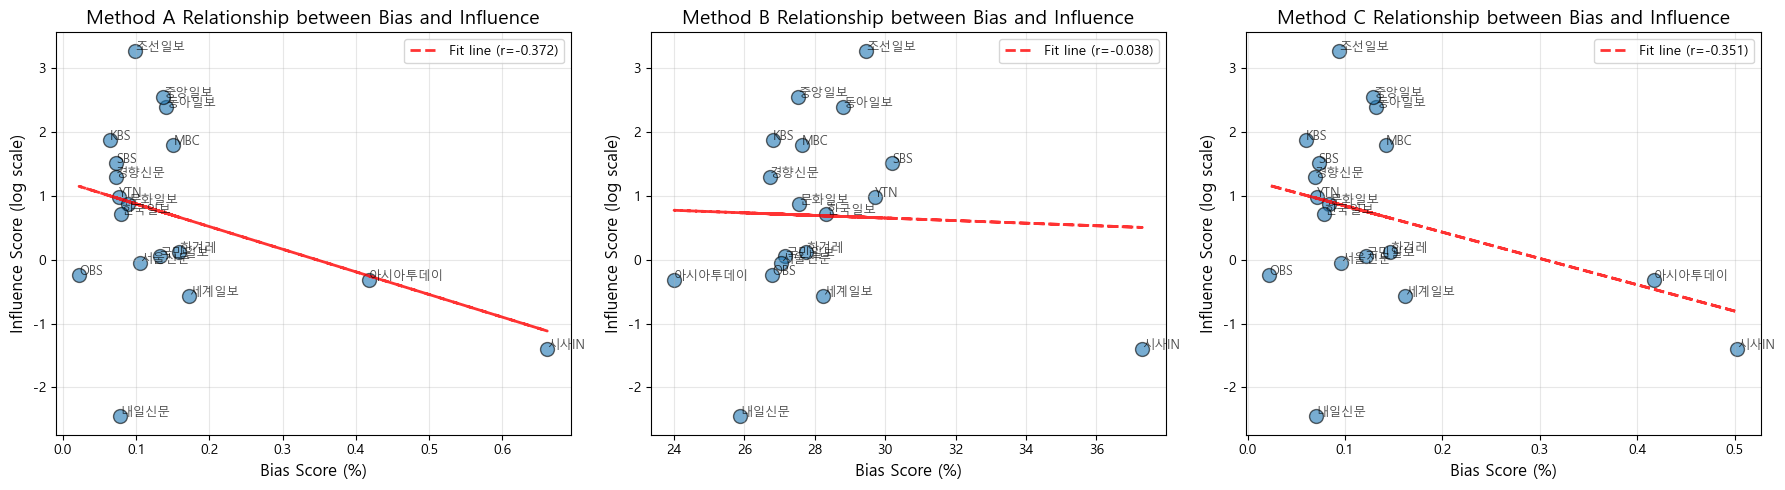

In [ ]:
methods = {
    'Method A': final_df_A,
    'Method B': final_df_B,
    'Method C': final_df_C
}

# Scatter plot with regression line
plt.figure(figsize=(18, 5))

for i, (method_name, df) in enumerate(methods.items(), 1):
    plt.subplot(1,3,i)

    # Scatter plot
    plt.scatter(df[f'Bias_Score_{method_name[-1]}'], df['Influence_Score'],
            s=100, alpha=0.6, edgecolors='black')


    # Add regression line
    z = np.polyfit(df[f'Bias_Score_{method_name[-1]}'], df['Influence_Score'], 1)
    p = np.poly1d(z)
    r = df[f'Bias_Score_{method_name[-1]}'].corr(df['Influence_Score'])
    plt.plot(df[f'Bias_Score_{method_name[-1]}'], p(df[f'Bias_Score_{method_name[-1]}']),
             "r--", alpha=0.8, linewidth=2, label=f'Fit line (r={r:.3f})')


    # Add media names
    for idx, row in df.iterrows():
        plt.annotate(row[MEDIA_COL],
                    (row[f'Bias_Score_{method_name[-1]}'], row['Influence_Score']),
                    fontsize=9, alpha=0.7)


    plt.xlabel('Bias Score (%)', fontsize=12)
    plt.ylabel('Influence Score (log scale)', fontsize=12)
    plt.title(f'{method_name} Relationship between Bias and Influence', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **Clustering (K-Means) :**

C:\Users\schmi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\schmi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\schmi\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\schmi\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^


=== Clustering for method A ===
Inertia values:
K=2: 17.82
K=3: 8.25
K=4: 5.28
K=5: 3.62
K=6: 1.93
K=7: 1.40

=== Clustering for method B ===
Inertia values:
K=2: 20.85
K=3: 9.15
K=4: 6.32
K=5: 4.59
K=6: 3.14
K=7: 1.73

=== Clustering for method C ===
Inertia values:
K=2: 17.06
K=3: 7.49
K=4: 4.49
K=5: 2.69
K=6: 2.02
K=7: 1.48


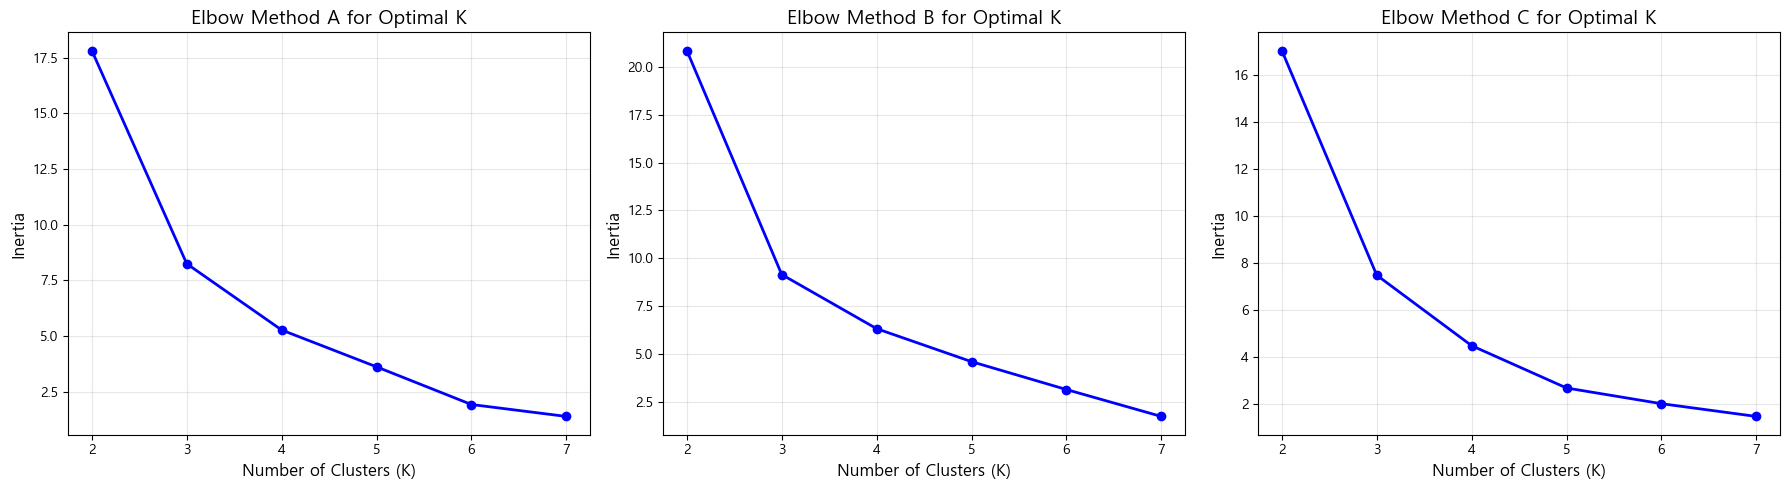

In [ ]:
methods = {
    'A': final_df_A,
    'B': final_df_B,
    'C': final_df_C
}

plt.figure(figsize=(18, 5))

# Elbow method
for i, (method, df) in enumerate(methods.items(), 1):
    bias_col = f'Bias_Score_{method}'

    # Features
    X = df[[bias_col, "Influence_Score"]].values

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Elbow method
    inertias = []
    K_range = range(2, min(8, len(df)))

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)


    plt.subplot(1, 3, i)
    plt.plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=6)
    plt.xlabel('Number of Clusters (K)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.title(f'Elbow Method {method} for Optimal K', fontsize=14)
    plt.grid(True, alpha=0.3)

    print(f"\n=== Clustering for method {method} ===")
    print("Inertia values:")
    for k, inertia in zip(K_range, inertias):
        print(f"K={k}: {inertia:.2f}")

plt.tight_layout()
plt.show()

In [ ]:
# Apply K-Means
optimal_k = 3


for method, df in methods.items():
    bias_col = f'Bias_Score_{method}'
    X = df[[bias_col, "Influence_Score"]].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df["cluster"] = kmeans.fit_predict(X_scaled)

    print(f"\n=== Cluster Summary for Method {method} (K={optimal_k}) ===")
    for cluster_id in range(optimal_k):
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"\nCluster {cluster_id}:")
        print(f"  Count: {len(cluster_data)}")
        print(f"  Avg Bias Score: {cluster_data[bias_col].mean():.2f}")
        print(f"  Avg Influence Score: {cluster_data['Influence_Score'].mean():.2f}")
        print(f"  Media: {', '.join(cluster_data[MEDIA_COL].tolist())}")

    print("\n=== Full Results ===")
    print(df[[MEDIA_COL, bias_col, "Influence_Score", "cluster"]].sort_values('cluster'))




=== Cluster Summary for Method A (K=3) ===

Cluster 0:
  Count: 6
  Avg Bias Score: 0.11
  Avg Influence Score: -0.52
  Media: OBS, 국민일보, 내일신문, 서울신문, 세계일보, 한겨레

Cluster 1:
  Count: 2
  Avg Bias Score: 0.54
  Avg Influence Score: -0.85
  Media: 시사IN, 아시아투데이

Cluster 2:
  Count: 10
  Avg Bias Score: 0.10
  Avg Influence Score: 1.73
  Media: KBS, MBC, SBS, YTN, 경향신문, 동아일보, 문화일보, 조선일보, 중앙일보, 한국일보

=== Full Results ===
       언론사  Bias_Score_A  Influence_Score  cluster
2      OBS      0.022094        -0.235616        0
7     내일신문      0.077959        -2.453414        0
6     국민일보      0.132243         0.058393        0
11    세계일보      0.172093        -0.562838        0
10    서울신문      0.105825        -0.042057        0
16     한겨레      0.159042         0.120395        0
12    시사IN      0.661437        -1.388996        1
13  아시아투데이      0.417988        -0.319498        1
4      YTN      0.077037         0.979956        2
5     경향신문      0.072920         1.303806        2
1      MBC      0.15

### Visualization

In [ ]:
# Enhanced scatter plot
plt.figure(figsize=(12, 8))

# List method of clustering
methods_cl = ['KMeans', 'Agglomerative', 'DBSCAN']

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for method in methods_cl:
    plt.figure(figsize=(12, 8))

    cluster_col = f'cluster_{method}'
    cluster_labels = df[cluster_col]
    cluster_colors = [colors[i % len(colors)] if i != -1 else '#CCCCCC' for i in cluster_labels]  # DBSCAN: -1 = noise

    # Scatter plot
    plt.scatter(
        df["Bias_Score"],
        df["Influence_Score"],
        c=cluster_colors,
        s=200,
        alpha=0.6,
        edgecolors='black',
        linewidths=1.5
    )

    # Labels
    for idx, row in df.iterrows():
        plt.annotate(
            row[MEDIA_COL],
            (row['Bias_Score'], row['Influence_Score']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=10,
            alpha=0.8,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )

    # Centres pour les méthodes qui en ont
    if method == 'KMeans' or method == 'Agglomerative':  # Agglo peut calculer un centre moyen
        if method == 'KMeans':
            centers = scaler.inverse_transform(kmeans.cluster_centers_)
        else:
            centers = np.array([df[df[cluster_col]==i][['Bias_Score', 'Influence_Score']].mean().values
                                for i in cluster_labels.unique() if i != -1])

        plt.scatter(
            centers[:, 0],
            centers[:, 1],
            marker='X',
            s=500,
            c='red',
            edgecolors='black',
            linewidths=2,
            label='Cluster Centers',
            zorder=10
        )

    # Axes, titre et légende
    plt.xlabel('Bias Score (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Influence Score (log scale)', fontsize=14, fontweight='bold')
    plt.yscale('log')
    plt.title(f'News Bias vs Audience Influence ({method} Clustering)',
              fontsize=16, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

KeyError: 'cluster_KMeans'

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

### Key Insights & Conclusions

In [ ]:
print("="*70)
print("KEY FINDINGS")
print("="*70)

print("\n1. OVERALL CORRELATION")
print(f"   - Bias-Influence correlation: {correlation:.4f}")
if abs(correlation) < 0.3:
    print("   → Weak correlation")
elif abs(correlation) < 0.7:
    print("   → Moderate correlation")
else:
    print("   → Strong correlation")

print("\n2. BIAS DISTRIBUTION")
print(f"   - Mean: {df['Bias_Score'].mean():.2f}%")
print(f"   - Median: {df['Bias_Score'].median():.2f}%")
print(f"   - Range: {df['Bias_Score'].min():.2f}% - {df['Bias_Score'].max():.2f}%")

print("\n3. INFLUENCE DISTRIBUTION")
print(f"   - Mean: {df['Influence_Score'].mean():.2f}")
print(f"   - Median: {df['Influence_Score'].median():.2f}")

print("\n4. EXTREME CASES")
print(f"   Highest Bias: {df.loc[df['Bias_Score'].idxmax(), MEDIA_COL]} ({df['Bias_Score'].max():.2f}%)")
print(f"   Lowest Bias: {df.loc[df['Bias_Score'].idxmin(), MEDIA_COL]} ({df['Bias_Score'].min():.2f}%)")
print(f"   Highest Influence: {df.loc[df['Influence_Score'].idxmax(), MEDIA_COL]} ({df['Influence_Score'].max():.2f})")
print(f"   Lowest Influence: {df.loc[df['Influence_Score'].idxmin(), MEDIA_COL]} ({df['Influence_Score'].min():.2f})")

print("\n" + "="*70)

KEY FINDINGS

1. OVERALL CORRELATION


NameError: name 'correlation' is not defined

In [ ]:
# === Export bias scores per method ===

final_df_A[[MEDIA_COL, "Bias_Score_A"]].to_csv(
    "bias_scores_method1.csv", index=False, encoding="utf-8-sig"
)
final_df_B[[MEDIA_COL, "Bias_Score_B"]].to_csv(
    "bias_scores_method2.csv", index=False, encoding="utf-8-sig"
)
final_df_C[[MEDIA_COL, "Bias_Score_C"]].to_csv(
    "bias_scores_method3.csv", index=False, encoding="utf-8-sig"
)

print("✓ Exported bias score files for Methods 1, 2, 3")


# === Export influence scores ===
df[[MEDIA_COL, "Influence_Score"]].to_csv(
    "influence_data.csv", index=False, encoding="utf-8-sig"
)

print("✓ Exported influence_data.csv")
print(f"✓ Total media outlets: {len(df)}")


# === Check 조선일보 for each method ===
print("\n=== 조선일보 Information ===")

for method_name, df, score_col in [
    ("Method A", final_df_A, "Bias_Score_A"),
    ("Method B", final_df_B, "Bias_Score_B"),
    ("Method C", final_df_C, "Bias_Score_C")
]:
    if '조선일보' in df[MEDIA_COL].values:
        chosun = df[df[MEDIA_COL] == '조선일보'].iloc[0]
        print(f"\n{method_name}:")
        print(f"  - Bias Score: {chosun[score_col]:.4f}%")
    else:
        print(f"\n{method_name}: 조선일보 not found in this dataset.")

# Influence score from final_df
if '조선일보' in df[MEDIA_COL].values:
    chosun_inf = df[df[MEDIA_COL] == '조선일보'].iloc[0]
    print(f"\nInfluence Score: {chosun_inf['Influence_Score']:.4f}")

    if "cluster" in df.columns:
        print(f"Cluster: {int(chosun_inf['cluster'])}")
else:
    print("\n⚠ 조선일보 not found in final_df.")


✓ Exported bias score files for Methods 1, 2, 3
✓ Exported influence_data.csv
✓ Total media outlets: 18

=== 조선일보 Information ===

Method A:
  - Bias Score: 0.0989%

Method B:
  - Bias Score: 29.4663%

Method C:
  - Bias Score: 0.0938%

Influence Score: 3.2786
Cluster: 2
